In [5]:
import numpy as np
from matplotlib import pyplot as plt

In [46]:
# クリック率θに相当する配列
# θは0以上1以下の連続値だがコンピュータだとそのまま扱えないので、できるだけ細かく刻んだ確率変数の配列を用意して信念p(θ)を確立質量関数に近似させる
thetas = np.linspace(0, 1, 1001)
print(thetas)

[0.    0.001 0.002 ... 0.998 0.999 1.   ]


In [6]:
# 尤度関数
# 以下式をシンプルに書き下した形
# p(r = 1 | θ) = θ
# p(r = 0 | θ) = 1 - θ
# rには0か1が入る
likelihood = lambda r: thetas if r else (1 - thetas)

In [7]:
# 事後分布を算出する関数
# 尤度関数と事前分布の積を合計が1になるように正規化したもの
# 尤度関数と事前分布の積をlpとし、その合計lp.sum()で割る
def posterior(r, prior):
    lp = likelihood(r) * prior
    return lp / lp.sum()

In [12]:
# 信念p(θ) = 事前分布(ここでは一様分布にしてる)
p = np.array([1 / len(thetas) for _ in thetas])
print(p)

[0.000999 0.000999 0.000999 ... 0.000999 0.000999 0.000999]


In [13]:
p = posterior(1, p) # クリック
print(p)

[0.00000000e+00 1.99800200e-06 3.99600400e-06 ... 1.99400599e-03
 1.99600400e-03 1.99800200e-03]


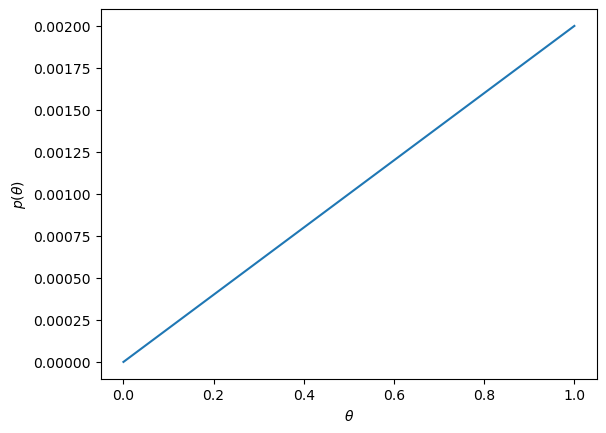

In [14]:
plt.plot(thetas, p)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.show()

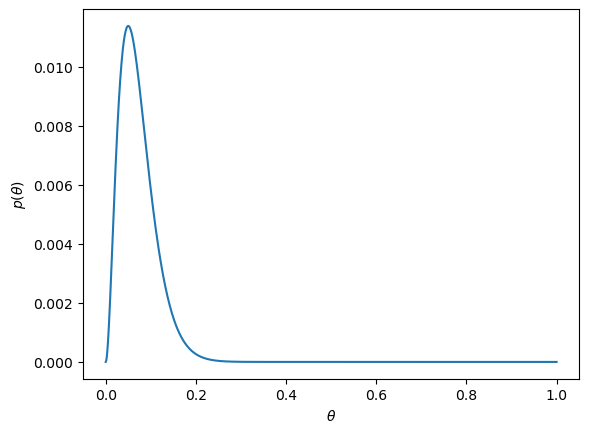

In [20]:
# アリスのレポートのデザイン案A
clicks = 2
noclicks = 38

# 事前分布(一様分布)
p = np.array([1 / len(thetas) for theta in thetas])

# ベイズ更新
for _ in range(clicks):
    p = posterior(1, p)
for _ in range(noclicks):
    p = posterior(0, p)

plt.plot(thetas, p)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.show()

In [22]:
def posterior_by_report(imps, clicks):
    noclicks = imps - clicks
    
    # 事前分布(一様分布)
    p = np.array([1 / len(thetas) for theta in thetas])

    # ベイズ更新
    for _ in range(clicks):
        p = posterior(1, p)
    for _ in range(noclicks):
        p = posterior(0, p)
    return p

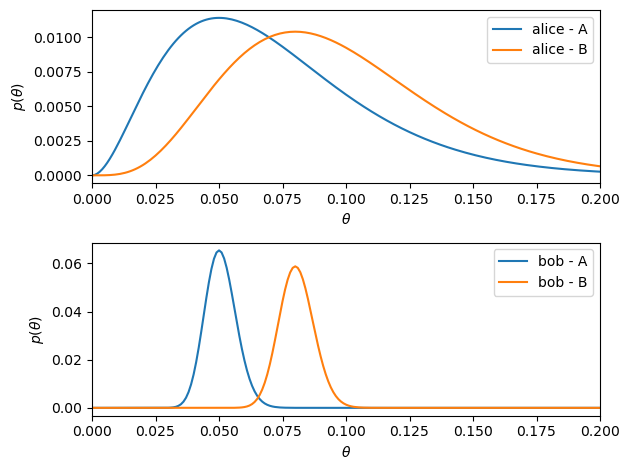

In [43]:
# アリスのレポートのデザイン案A
alice_a_clicks = 2
alice_a_imps = 40

# アリスのレポートのデザイン案B
alice_b_clicks = 4
alice_b_imps = 50

# ボブのレポートのデザイン案A
bob_a_clicks = 64
bob_a_imps = 1280

# アリスのレポートのデザイン案B
bob_b_clicks = 128
bob_b_imps = 1600

alice_a_p = posterior_by_report(alice_a_imps, alice_a_clicks)
alice_b_p = posterior_by_report(alice_b_imps, alice_b_clicks)
bob_a_p = posterior_by_report(bob_a_imps, bob_a_clicks)
bob_b_p = posterior_by_report(bob_b_imps, bob_b_clicks)

plt.subplot(2, 1, 1)
plt.plot(thetas, alice_a_p, label="alice - A")
plt.plot(thetas, alice_b_p, label="alice - B")
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0, 0.2)
plt.legend() # 凡例の表示
plt.subplot(2, 1, 2)
plt.plot(thetas, bob_a_p, label="bob - A")
plt.plot(thetas, bob_b_p, label="bob - B")
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0, 0.2)
plt.legend()
plt.tight_layout()
plt.show()

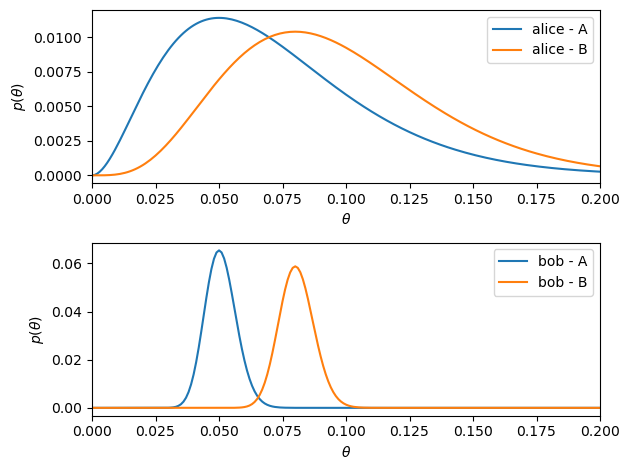

In [48]:
# 尤度関数をベルヌーイ分布から二項分布に変更
# 二項分布は、ベルヌーイ試行をN回行った時の成功回数aが従う確率分布
# N = 1の時はベルヌーイ分布と一致する
likelihood_binomial = lambda a, N: thetas ** a * (1 - thetas) ** (N - a)

def posterior_binomial(a, N, prior):
    lp = likelihood_binomial(a, N) * prior
    return lp / lp.sum()

# 事前分布(一様分布)
prior = 1 / len(thetas)

plt.subplot(2, 1, 1)
plt.plot(thetas, posterior_binomial(alice_a_clicks, alice_a_imps, prior), label="alice - A")
plt.plot(thetas, posterior_binomial(alice_b_clicks, alice_b_imps, prior), label="alice - B")
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0, 0.2)
plt.legend() # 凡例の表示
plt.subplot(2, 1, 2)
plt.plot(thetas, posterior_binomial(bob_a_clicks, bob_a_imps, prior), label="bob - A")
plt.plot(thetas, posterior_binomial(bob_b_clicks, bob_b_imps, prior), label="bob - B")
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0, 0.2)
plt.legend()
plt.tight_layout()
plt.show()

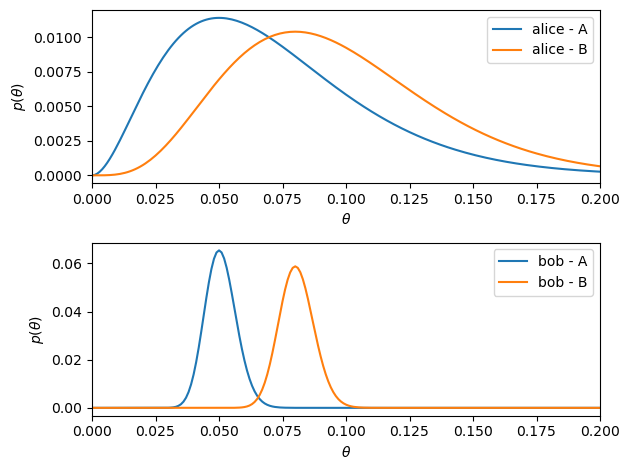

In [53]:
# ベータ分布
# def betaf(alpha, beta):
#     numerator = thetas ** (alpha - 1) * (1 - alpha) ** (beta - 1)
#     return numerator / numerator.sum() # 離散確率分布による近似のテクニック

# ベータ分布(改良後)
def betaf(alpha, beta):
    # 0や1近辺の値をクリップして計算を安定化
    clipped_thetas = np.clip(thetas, 1e-10, 1 - 1e-10)

    log_numerator = (alpha - 1) * np.log(clipped_thetas) + (beta - 1) * np.log(1 - clipped_thetas)
    log_denominator = np.log(np.sum(np.exp(log_numerator))) # 正規化
    return np.exp(log_numerator - log_denominator) # 対数空間で計算した結果を元に戻す

def posterior_betaf(a, N):
    return betaf(a + 1, N - a + 1) # 事後分布はα = a + 1, β = N - a + 1のベータ分布で表される

plt.subplot(2, 1, 1)
plt.plot(thetas, posterior_betaf(alice_a_clicks, alice_a_imps), label="alice - A")
plt.plot(thetas, posterior_betaf(alice_b_clicks, alice_b_imps), label="alice - B")
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0, 0.2)
plt.legend() # 凡例の表示
plt.subplot(2, 1, 2)
plt.plot(thetas, posterior_betaf(bob_a_clicks, bob_a_imps), label="bob - A")
plt.plot(thetas, posterior_betaf(bob_b_clicks, bob_b_imps), label="bob - B")
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0, 0.2)
plt.legend()
plt.tight_layout()
plt.show()

In [58]:
# HDIを使った仮設検定

# 確率質量ランキング上位の値の列を返す
# xs: 離散化された確率変数の配列
# ps: xsに対応する確率質量の配列
# alpha: HDIによってカバーしたい確率
# 返り値: 確率変数の値の配列
def hmv(xs, ps, alpha = 0.95):
    # xsとpsをまとめて、確率質量の高順で並び替え
    xps = sorted(zip(xs, ps), key = lambda xp: xp[1], reverse = True)
    xps = np.array(xps)
    xs = xps[:, 0]
    ps = xps[:, 1]
    return np.sort(xs[np.cumsum(ps) <= alpha])

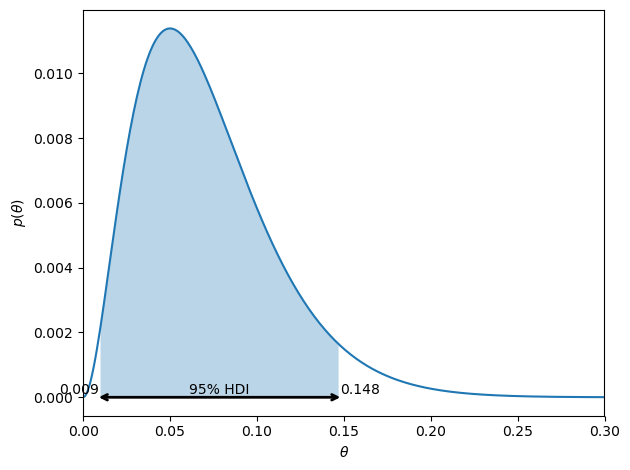

In [59]:
alice_a_posterior = posterior_betaf(alice_a_clicks, alice_a_imps)
hm_thetas = hmv(thetas, alice_a_posterior, alpha = 0.95)

plt.plot(thetas, alice_a_posterior)
plt.annotate(
    "",
    xy = (hm_thetas.min(), 0),
    xytext = (hm_thetas.max(), 0),
    arrowprops = dict(color = "black", shrinkA = 0, shrinkB = 0, arrowstyle = "<->", linewidth = 2)
)
plt.annotate("%.3f" % hm_thetas.min(), xy = (hm_thetas.min(), 0), ha = "right", va = "bottom")
plt.annotate("%.3f" % hm_thetas.max(), xy = (hm_thetas.max(), 0), ha = "left", va = "bottom")
plt.annotate("95% HDI", xy = (hm_thetas.mean(), 0), ha = "center", va = "bottom")
hm_region = (hm_thetas.min() < thetas) & (thetas < hm_thetas.max())
plt.fill_between(thetas[hm_region], alice_a_posterior[hm_region], 0, alpha = 0.3)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0, 0.3)
plt.tight_layout()
plt.show()

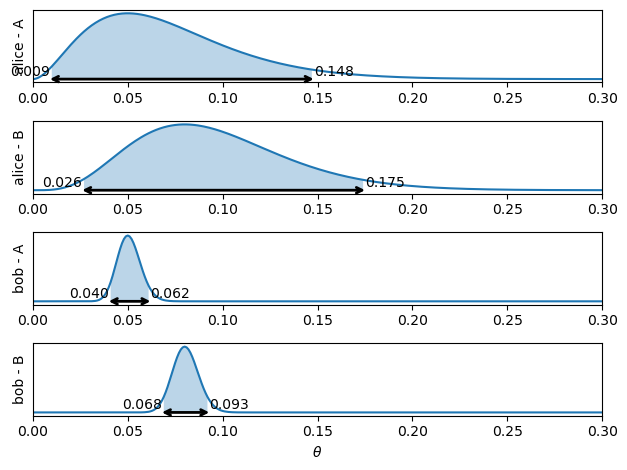

In [62]:
def plot_hdi(ps, label):
    hm_thetas = hmv(thetas, ps, 0.95)
    plt.plot(thetas, ps)
    plt.annotate(
        "",
        xy = (hm_thetas.min(), 0),
        xytext = (hm_thetas.max(), 0),
        arrowprops = dict(color = "black", shrinkA = 0, shrinkB = 0, arrowstyle = "<->", linewidth = 2)
    )
    plt.annotate("%.3f" % hm_thetas.min(), xy = (hm_thetas.min(), 0), ha = "right", va = "bottom")
    plt.annotate("%.3f" % hm_thetas.max(), xy = (hm_thetas.max(), 0), ha = "left", va = "bottom")
    hm_region = (hm_thetas.min() < thetas) & (thetas < hm_thetas.max())
    plt.fill_between(thetas[hm_region], ps[hm_region], 0, alpha = 0.3)
    plt.xlim(0, 0.3)
    plt.ylabel(label)
    plt.yticks([])

plt.subplot(4, 1, 1)
alice_a = posterior_betaf(alice_a_clicks, alice_a_imps)
plot_hdi(alice_a, "alice - A")

plt.subplot(4, 1, 2)
alice_b = posterior_betaf(alice_b_clicks, alice_b_imps)
plot_hdi(alice_b, "alice - B")

plt.subplot(4, 1, 3)
bob_a = posterior_betaf(bob_a_clicks, bob_a_imps)
plot_hdi(bob_a, "bob - A")

plt.subplot(4, 1, 4)
bob_b = posterior_betaf(bob_b_clicks, bob_b_imps)
plot_hdi(bob_b, "bob - B")

plt.xlabel(r'$\theta$')
plt.tight_layout()
plt.show()

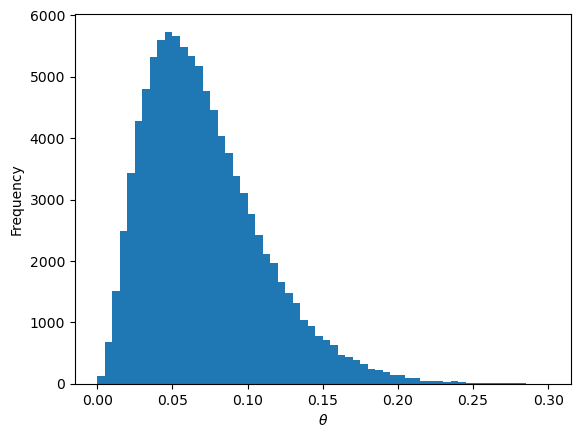

In [63]:
# A案のクリック率を表す確率変数をθa、B案のクリック率を表す確率変数をθbとして、A案とB案の差を表す新たな確率変数δは、
# δ = θb - θa
# と定義する
# δが従う確率分布p(δ)を求めるために、大量に値をサンプルしてp(δ)を推論する

# 確率分布から乱数を利用して確率変数θのサンプルを生成し、ヒストグラムで可視化
# アリスのレポートA案
data = np.random.beta(3, 39, size = 100000)
plt.hist(data, range = (0, 0.3), bins = 60)
plt.xlabel(r'$\theta$')
plt.ylabel('Frequency')
plt.show()

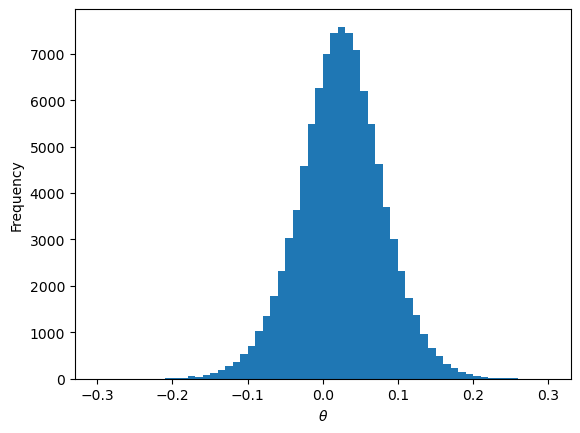

In [66]:
# アリスのレポートのデザイン案のクリック率の差を表す確率変数δのヒストグラム
theta_alice_a = np.random.beta(3, 39, size = 100000)
theta_alice_b = np.random.beta(5, 47, size = 100000)
delta = theta_alice_b - theta_alice_a
plt.hist(delta, range = (-0.3, 0.3), bins = 60)
plt.xlabel(r'$\theta$')
plt.ylabel('Frequency')
plt.show()